In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import prince
import importlib
import utils2
from utils2 import *


## Graph Overview - CA Prep

- In this notebook, I will perform various check in order to make sure my data is ready for CA implementation

- This includes:
    - Data distribution checks
    - Node and edge analysis; various graph metrics and visualisations. Are there any clusters etc?
    - Assumptions of CA?
    - Connectedness of my graph

I'm starting with an edge list. Each row represents an edge (a follower-brand relationship) in the graph. From the edge list, I should create a directed graph. 

In [2]:
#Load the edge list
#Load marker followers
full_path1 = '/home/livtollanes/NewData/markers_followers_cleaned_nolang.csv'
req_cols = ['marker_id', 'follower_id']
dtypes = {'marker_id': 'object',
          'follower_id': 'object'}

edgelist = pd.read_csv(full_path1, encoding='utf-8', dtype=dtypes, usecols=req_cols)

In [4]:
summary_stats(edgelist)

Shape of DataFrame:  (9614122, 2)

Columns in DataFrame:  ['marker_id', 'follower_id']

Data types of columns:
 marker_id      object
follower_id    object
dtype: object

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique values in 'marker_id':  235
Number of duplicate values in 'marker_id':  9613887

Number of missing values in each column:
'marker_id':  0
'follower_id':  0

Number of duplicate rows:  0


In [5]:
#Add twitter name to the edge list for more informative plots at a later stage

# Full path to the Excel file where types and names of brands are stored
file_path = '/home/livtollanes/SocialMarkers/MarkersFrenchTwitter.xlsx'

# Load the Excel file
cats = pd.read_excel(file_path)

The excel file does not contain twitter ID. We thus need to merge cats with the marker metadata file in order to get names and ids in the same df

In [6]:
# Load the marker bios and rename ID columns
full_path = '/home/livtollanes/SocialMarkers/markers_bios_2023-05-19.csv'

req_cols = ['twitter_name', 'id', 'description', 'verified', 'tweets', 'followers']

dtypes = {
    'twitter_name': 'object',
    'id': 'object',
    'description': 'object',
    'tweets': 'int64',
    'followers': 'int64'}

marker_ids = pd.read_csv(full_path, usecols=req_cols, dtype=dtypes)

#rename the twittwer id column to follower id 
marker_ids.rename(columns={'id':'marker_id'}, inplace=True)

In [8]:
#map marker_ids onto cats from marker:ids
cat_id = cats.merge(marker_ids, on='twitter_name', how='left')
cat_id = cat_id.drop_duplicates(subset='marker_id')

In [10]:
#streamline cat_id and edge list. Only include ids in cat id that exist in edge list
streamline_IDs(edgelist, cat_id, 'marker_id')

Number of unique marker_id in source DataFrame: 235
Number of unique marker_id in filtered DataFrame after filtering: 235
Removed 2 rows from the DataFrame to be filtered.
235 rows are left in the filtered DataFrame.


,marque,twitter_name,type,Unnamed: 3,marker_id,description,verified,tweets,followers
0,Nike,Nike,sport,NaN,415859364,#BlackLivesMatter and #StopAsianHate,0.0,38240.0,9788339.0
1,Adidas,adidasFR,sport,NaN,25487201,𝕭𝖎𝖊𝖓𝖛𝖊𝖓𝖚𝖊 𝖆𝖚 𝕮𝖑𝖚𝖇 𝕺𝖗𝖎𝖌𝖎𝖓𝖆𝖑𝖘.,0.0,16680.0,393006.0
2,Lacoste,Lacoste,sport,NaN,18481641,Moving with the world for 90 years. 🐊 #Lacoste...,0.0,9852.0,1074248.0
3,Converse,Converse,sport,NaN,183398746,Get inspired by the next generation of artists...,0.0,9937.0,1035205.0
4,Moncler,Moncler,sport,NaN,187897893,"Born in the mountains, lives in the city. The ...",0.0,4381.0,1108498.0
...,...,...,...,...,...,...,...,...,...
235,Cdiscount,Cdiscount,commerce,NaN,63142684,Vous faites le choix du e-commerce français 🇫🇷,0.0,138131.0,616438.0
236,FNAC,Fnac,commerce,NaN,8806412,Compte officiel de la #Fnac : Actu High Tech /...,0.0,220101.0,501158.0
237,Rue du Commerce,rueducommerce,commerce,NaN,16933084,Retrouvez chaque jour des promos #hightech exc...,0.0,84158.0,206990.0
238,Vinted,vinted,commerce,NaN,2228641753,Second-hand marketplace. Give your clothes a s...,0.0,5402.0,23290.0


In [11]:
#Get the twitter_name column from cat_id into the edge list by merging on marker_id

edgelist = edgelist.merge(cat_id[['marker_id', 'twitter_name']], on='marker_id', how='left')

edgelist.head()

,marker_id,follower_id,twitter_name
0,415859364,1301293067945807877,Nike
1,415859364,1233001848006729729,Nike
2,415859364,2768568386,Nike
3,415859364,1152271993225433089,Nike
4,415859364,947287974882021377,Nike


In [12]:
summary_stats(edgelist)

Shape of DataFrame:  (9614122, 3)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name']

Data types of columns:
 marker_id       object
follower_id     object
twitter_name    object
dtype: object

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique values in 'marker_id':  235
Number of duplicate values in 'marker_id':  9613887

Number of missing values in each column:
'marker_id':  0
'follower_id':  0
'twitter_name':  0

Number of duplicate rows:  0


Informative subset (Optional)

#It might be a good idea to use the most informative subset of my data, like in the original study (He and Tsvetkova.) They selected users who follow at least one brand across all their brand domains. I have more domains thn them (12 vs. 6). The chance that people follow all 12 is small. If I am to filter my data like they do, it maybe makes more sense to look at people who follow at least half of the brands. 

In [9]:
#inspect the marker_bios data for marker_ID 1059975643
row = cat_id.loc[cat_id['marker_id'] == '1059975643']

# Print the row
print(row)

        marque  twitter_name   type Unnamed: 3   marker_id description  \
18  Napapijiri  Napapijiri97  sport        NaN  1059975643         NaN   

    verified  tweets  followers  
18       0.0     8.0        1.0  


Make dge list into a graph.
An edge list is a simple, tabular representation of a graph, while a graph is amore complex data structure that allows for more advance operations, such s finding paths and calculating graph metrics.

In [17]:
edgelist.columns

Index(['marker_id', 'follower_id', 'twitter_name'], dtype='object')

### Graph metrics

In [18]:

# Create a new bipartite graph
B = nx.DiGraph() #directed graph

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(edgelist['follower_id'].unique(), bipartite=0) #adding a node for each unique follower. Set 1 in the bipartite graph
B.add_nodes_from(edgelist['twitter_name'].unique(), bipartite=1) #adding a node for each unique marker. Set 2 in the bipartite graph
 
# Add edges
B.add_edges_from(list(zip(edgelist['follower_id'], edgelist['twitter_name'])))  #edges are directed from the first to the second element. So direction is; follower --> Marker

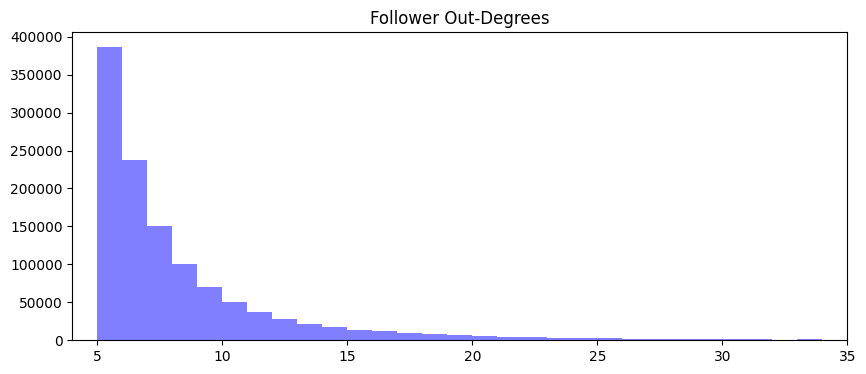

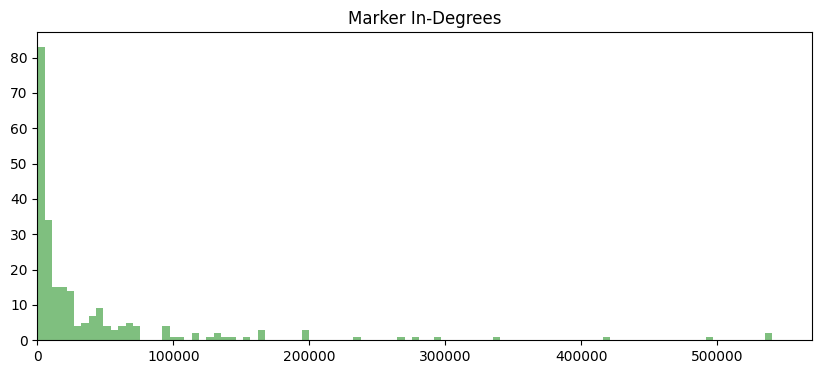

In [19]:
# Analyse and visualise degree distribution (number of edges connected to each node)

# Separate the nodes by type
follower_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
marker_nodes = set(B) - follower_nodes

# Calculate the out-degree of each follower node and in-degree of each marker node
follower_out_degrees = [B.out_degree(n) for n in follower_nodes]
marker_in_degrees = [B.in_degree(n) for n in marker_nodes]

# Plot the out-degree distribution of follower nodes
bins = range(4, 35)

plt.figure(figsize=(10, 4))
plt.hist(follower_out_degrees, bins = bins, alpha=0.5, color='blue')
plt.title('Follower Out-Degrees')
plt.xlim(4, 35)
plt.show()

# Plot the in-degree distribution of marker nodes
plt.figure(figsize=(10, 4))
plt.hist(marker_in_degrees, bins = 100, alpha=0.5, color='green')
plt.title('Marker In-Degrees')
plt.xlim(0, 570000)
plt.show()

- As we can see based on the marker in-degrees plot, a select few brans have a lot of connections compared to teh rest of the markers
- From the follower Out-degree plot, it is evident that most users don't follow more than 10 brands. Following more than 15 brands is even less normal. 

In [20]:
# Calculate weakly connected components
connected_components = list(nx.weakly_connected_components(B))

# Print the number of connected components
print("Number of connected components:", len(connected_components))

# Print the size of the largest connected component
print("Size of largest connected component:", max(len(c) for c in connected_components))

Number of connected components: 1
Size of largest connected component: 1192767


A weakly connected component is a subgraph of the original graph where all vertices are connected to each other by some path, ignoring the direction of edges. Given our number of connected components is 1, we can conclude that our graph is fully connected. 

In [21]:
# Calculate in-degree centrality for all nodes in the graph
in_degree_centrality = nx.in_degree_centrality(B)

# Top 5 nodes by in-degree centrality
top_in_degree_nodes = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top nodes by in-degree centrality:", top_in_degree_nodes)



Top nodes by in-degree centrality: [('Dior', 0.45296311263064176), ('LouisVuitton', 0.45275938448949754), ('CHANEL', 0.41497242543801555), ('YSL', 0.34924369071553013), ('Nike', 0.28177781727514034)]


In [74]:
# Number of brands
num_brands = len(edgelist['twitter_name'].unique())

# Calculate out-degree for each follower and divide by the number of brands
out_degree_centrality = {follower: out_degree / num_brands for follower, out_degree in B.out_degree() if B.nodes[follower]['bipartite'] == 0}

# Top 5 nodes by out-degree centrality
top_out_degree_nodes = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top nodes by out-degree centrality:", top_out_degree_nodes)

Top nodes by out-degree centrality: [('35704105', 0.6340425531914894), ('107042704', 0.4595744680851064), ('1430557124132839431', 0.4425531914893617), ('525429842', 0.4127659574468085), ('819576166055104516', 0.40425531914893614)]


In [ ]:
#Some users follow a lot of brands. Maybe a bit unlikely?
top_followers = edgelist.groupby('follower_id').size().sort_values(ascending=False).head(5)
print(top_followers)

In [75]:
summary_stats(edgelist, print_dtypes=True)

Shape of DataFrame:  (9730265, 3)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name']

Data types of columns:
 marker_id       object
follower_id     object
twitter_name    object
dtype: object

Number of unique values in 'follower_id':  1192532

Number of duplicate values in 'follower_id':  8537733

Number of unique values in 'marker_id':  235

Number of duplicate values in 'marker_id':  9730030

Number of missing values in each column:
 marker_id       0
follower_id     0
twitter_name    0
dtype: int64


In [22]:
#Save edgelist to csv 
edgelist.to_csv('/home/livtollanes/NewData/edgelist.csv', index=False, encoding='utf-8')

## The CA

- Create contingency table (rows are users, columns are brands)
- each cell represents the frequency of interaction between user and brand


In [82]:
# load data
path = '/home/livtollanes/NewData/edgelist.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object'}


edgelist_CA = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

In [84]:
summary_stats(edgelist_CA)

Shape of DataFrame:  (9730265, 3)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name']

Data types of columns:
 marker_id       object
follower_id     object
twitter_name    object
dtype: object

Number of unique values in 'follower_id':  1192532

Number of duplicate values in 'follower_id':  8537733

Number of unique values in 'marker_id':  235

Number of duplicate values in 'marker_id':  9730030

Number of missing values in each column:
 marker_id       0
follower_id     0
twitter_name    0
dtype: int64


In [91]:
duplicates = edgelist_CA[edgelist_CA.duplicated(keep=False)]
duplicates = duplicates.sort_values(by=list(edgelist_CA.columns))
print(duplicates)

        marker_id          follower_id     twitter_name
6209987  25053299  1000004748681072640  FortuneMagazine
6452529  25053299  1000004748681072640  FortuneMagazine
6232580  25053299            100001557  FortuneMagazine
6475123  25053299            100001557  FortuneMagazine
6247659  25053299           1000030934  FortuneMagazine
...           ...                  ...              ...
6440430  25053299   999951622527770624  FortuneMagazine
6265754  25053299            999954668  FortuneMagazine
6508293  25053299            999954668  FortuneMagazine
6194801  25053299   999982985830174720  FortuneMagazine
6437344  25053299   999982985830174720  FortuneMagazine

[232286 rows x 3 columns]
